# Data Prep and Modelling

In [1]:
import pandas as pd
from IPython.display import HTML
#display(HTML("<style>.container { width:100% !important; }</style>")) ### This line makes our Jupyter notebook use the entire width of the screen

# Functions

## make_corpus (unused so far)

In [2]:
def make_corpus(dataset, column):
    '''This function reads in a pandas dataframe (dataset) and the column name (e.g. 'text_column'). 
    Then it strips all punctuation, makes it lower case, tokenizes it, and removes english stopwords. 
    Finally it returns two lists (either directly or via tuple unpacking. the first is the documents
    without stopwords; the second is the documents stemmed via porterstemmer.
    '''
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    stop_words = set(stopwords.words('english'))
    import string 
    import sys
    translator = str.maketrans('', '', string.punctuation)
    import re
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    filtered_text_list = []
    stemmed_text_list = []
    for i in range (0, len(dataset)):
        text = dataset.iloc[i][column].lower().translate(translator)
        text = re.sub('\n', ' ', text)
        word_tokens = word_tokenize(text) 
        filtered_text = [w for w in word_tokens if not w in stop_words]
        filtered_text = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_text.append(w)
        stemmed_text = []
        for w in filtered_text:
            stemmed_text.append(ps.stem(w))
        filtered_text_list.append(str(filtered_text).translate(translator))
        stemmed_text_list.append(str(stemmed_text).translate(translator))
        sys.stdout.write("\r" + "Creating Corpus.. Processing Record: " + str(i+1) + " of " + str(len(dataset)))
        sys.stdout.flush()
    print("\nDONE!")
    return filtered_text_list, stemmed_text_list

## wordcloud
wordcloud has been heavily tweaked to create super high DPI images, and therefore takes a long time to render.

In [3]:
def wordcloud(text):
    #d = path.dirname(__file__)
    #ottawa_mask = np.array(Image.open(path.join(d, "kpzQuih.jpg")))
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(font_path='/Library/Fonts/Graphik-thin.ttf',
                          collocations=False,
                          max_words = 300,
                          width = 4192,
                          height = 3684,
                          background_color="white",
                          ).generate(text)
    plt.figure(figsize=(30,30), dpi=300)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return;

## extract_topics
This used the sklearn TFIDF vectorizer to extract topics from text. We limite the features to reduce noise. This may be a bad idea, but we'll find out via experimentation.

In [4]:
def extract_topics(documents, no_features):
    '''Reads in a document and the number of features to extract. returns the extracted topics using TFIDF_Vectorizer'''
    from sklearn.feature_extraction.text import TfidfVectorizer
    #from sklearn.decomposition import NMF, LatentDirichletAllocation    
    #from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=no_features, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform([documents])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    return tfidf_feature_names

# Running Code

## Load the dataframe from a pickle (binary) format to avoid CSV bleed

In [5]:
dataset = pd.read_pickle('other_xmltodict_all_major_fields.pkl')
print("With Null rows: " + str(len(dataset)))
### Drop the rows with no values in section_bodies
dataset = dataset[dataset['section_bodies'] != 'Null']
print("Without Null rows: " + str(len(dataset)))

With Null rows: 4109
Without Null rows: 2520


In [6]:
dataset.head()

,consolidation_date,enabling_authority,enabling_type,file_name,instrument_number,language,last_modified_date,order_number,registration_date,regulation_maker,regulation_provision,regulation_type,repealed,section_bodies,section_labels,title
0,2018-06-11,ENVIRONMENTAL VIOLATIONS ADMINISTRATIVE MONETA...,act,Consolidation_Regs_1.2.0/EN/SOR-2017-109.xml,SOR/2017-109,en,2017-6-12,2017-568,2017-6-2,P.C.,His Excellency the Governor General in Council...,SOR,False,['The contravention of a provision of an Envir...,"['2', '3', '4', '5', '6', '7', '8', '9', '10',...",Environmental Violations Administrative Moneta...
1,2018-06-11,CANADA POST CORPORATION ACT,act,Consolidation_Regs_1.2.0/EN/SOR-85-567.xml,SOR/85-567,en,Null,1985-1954,1985-6-19,P.C.,"[{'@format-ref': 'indent-0-0', '@language-alig...",SOR,False,"['In these Regulations,', 'These Regulations a...","['2', '3', '4', '5', '6']",Regulations Respecting Mailable Matter Bearing...
2,2018-06-11,AERONAUTICS ACT,act,Consolidation_Regs_1.2.0/EN/SOR-93-293.xml,SOR/93-293,en,2011-6-7,1993-1203,1993-6-8,P.C.,"[{'@format-ref': 'indent-0-0', '@language-alig...",SOR,False,"['In these Regulations,', 'For the purposes of...","['2', '3', '4', '5', '6']",Regulations Respecting Zoning at Bagotville Ai...
3,2018-06-11,CUSTOMS TARIFF,act,Consolidation_Regs_1.2.0/EN/SOR-98-87.xml,SOR/98-87,en,2005-7-15,1997-2055,1997-12-29,P.C.,His Excellency the Governor General in Council...,SOR,False,"['Subject to sections 4 and 5, remission is he...","['2', '2.1', '2.2', '2.3', '2.3.1', '2.4', '2....","Shirting Fabrics Remission Order, 1998"
4,2018-06-11,AGRICULTURAL PRODUCTS MARKETING ACT,act,"Consolidation_Regs_1.2.0/EN/C.R.C.,_c._208.xml","C.R.C., c. 208",en,2005-5-31,Null,Null,Null,Null,SOR,False,"['In these Regulations,', 'These Regulations a...","['2', '3', '4', '5', '6', '7', '8', '9']",Regulations Respecting the Marketing in Interp...


### The make_corpus function returns a tuple which can be unpacked by naming 2 variables as below.

In [7]:
filtered_text, stemmed_text = make_corpus(dataset,'section_bodies')

Creating Corpus.. Processing Record: 2520 of 2520
DONE!


Let's see the difference between filtered (no stop words) and filtered and stemmed

In [8]:
display(filtered_text[400])
display(stemmed_text[400])

'purposes subparagraph 4411d1iii act prescribed purpose prescribed circumstance case property casualty company marine company purpose circumstance materially related provision financial products services company member company ’ group purposes paragraph 4954f act subject subsections 2 3 prescribed activity relation entity designing developing holding managing manufacturing selling otherwise dealing data transmission system information site communication device information platform portal used provide information services neither property casualty company marine company may acquire control hold acquire increase substantial investment entity engaging activity described subsection 1 sum following exceeds 5 company ’ regulatory capital neither property casualty company marine company may acquire control hold acquire increase substantial investment entity engaging activity described subsection 1 entity engages business accepting deposit liabilities activities entity include purposes subpara

'purpos subparagraph 4411d1iii act prescrib purpos prescrib circumst case properti casualti compani marin compani purpos circumst materi relat provis financi product servic compani member compani ’ group purpos paragraph 4954f act subject subsect 2 3 prescrib activ relat entiti design develop hold manag manufactur sell otherwis deal data transmiss system inform site commun devic inform platform portal use provid inform servic neither properti casualti compani marin compani may acquir control hold acquir increas substanti invest entiti engag activ describ subsect 1 sum follow exce 5 compani ’ regulatori capit neither properti casualti compani marin compani may acquir control hold acquir increas substanti invest entiti engag activ describ subsect 1 entiti engag busi accept deposit liabil activ entiti includ purpos subparagraph 33fii subsect 4956 8 act appli determin whether properti casualti compani marin compani would permit acquir substanti invest entiti subsect 4932 paragraph 4933b c 

## Topic Extraction

In [9]:
filtered_topics = []
for i in range(0, len(filtered_text)):
    filtered_topics.append(extract_topics(filtered_text[i], 50))

In [10]:
stemmed_topics = []
for i in range(0, len(stemmed_text)):
    stemmed_topics.append(extract_topics(stemmed_text[i], 50))

### Purging special characters
When you stringify lists, you end up with spurious [] and 's everywhere. The method below is the cleanest way I've found to elimineate it.
We're preparing strings because wordcloud expects a string as an input

In [11]:
import string
from translate import Translator
translator = str.maketrans('', '', string.punctuation)

filtered_topics_string = str(filtered_topics).lower().translate(translator)
stemmed_topics_string = str(stemmed_topics).lower().translate(translator)


## Wordclouds
Wordclouds are a neat way (at least I think so :)) of interrogating data quickly to see what the highest frequeny terms are. We can use our intuition to identify common terms that should be eliminated.

Note there's a significant difference between the filtered and stemmed topics.

In [13]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#for some reason I was getting an error message and so used a different approach for generating the word cloud
## https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python


--------------Filtered--------------


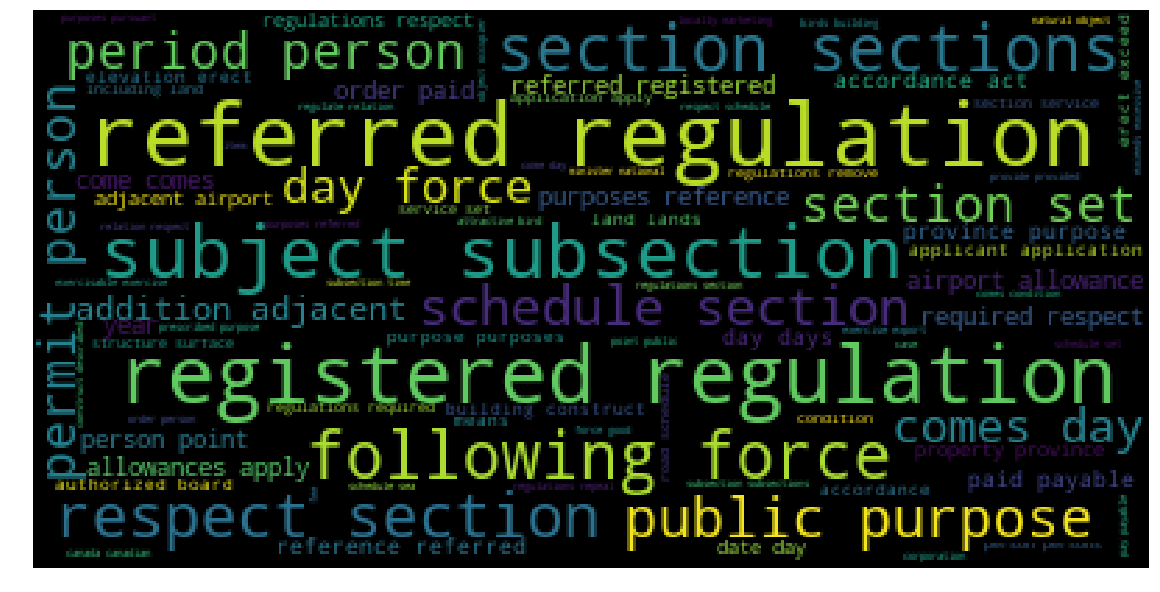

In [14]:
print("--------------Filtered--------------")
wordcloud = WordCloud(max_words=200).generate(filtered_topics_string)

fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud)

--------------Stemmed--------------


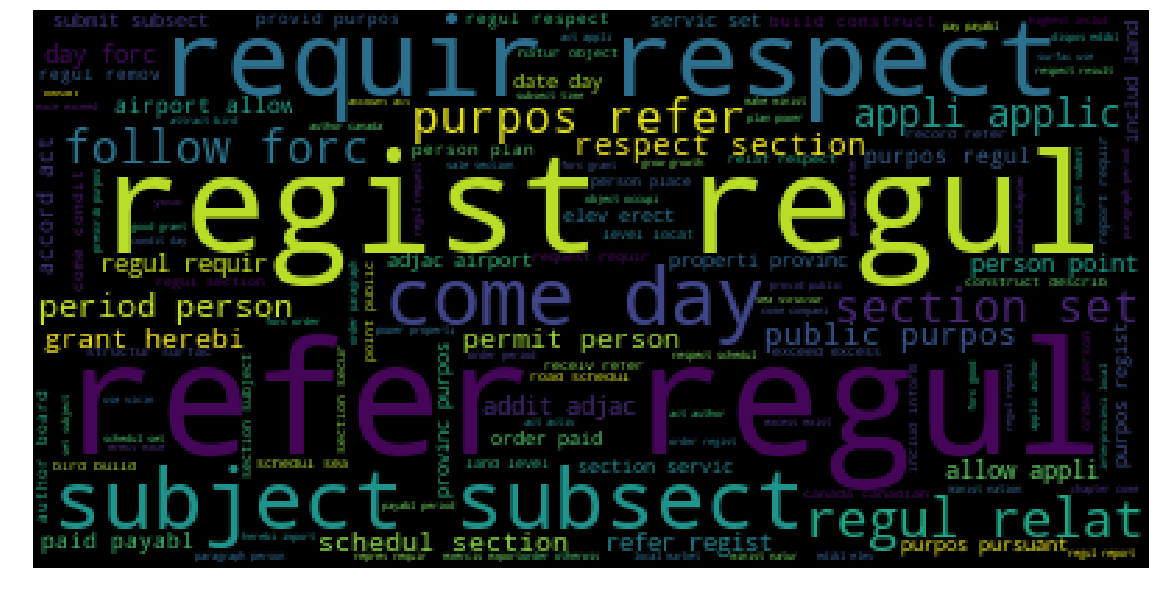

In [15]:
print("--------------Stemmed--------------")
wordcloud = WordCloud(max_words=200).generate(stemmed_topics_string)

fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud)

In [19]:
#Top words from the stemmed word cloud
top_words = list(set(['submit','subset','respect','set','day','forc','requir','date','day','purpos','refer','appli',
             'applic','follow','forc','respect','section','regist','regul','requir','adjac','properti','provinc',
             'person','point','period','person','come','section','set','grant','herebi','public','purpos','refer',
             'addit','adjac','regul','order','paid','section','servic','subject','subsect','relat','paid','payabl',
             'schedul','section','regist','purpos','pursuant']))
